In [1]:
import math                      
import matplotlib.pyplot as plt  
import scipy                     
import cv2                       
import numpy as np               
import glob                      
import os                        
import pandas as pd              
import tensorflow as tf       
import itertools
import random
from random import shuffle 
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import seaborn as sns

%matplotlib inline
np.random.seed(1)

C:\ProgramData\Anaconda3\envs\Tensorflow1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\Tensorflow1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\Tensorflow1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\Tensorflow1\lib\site-pack

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [3]:
TRAIN_PATH = './input/training/training/'
VALID_PATH = './input/validation/validation/'
TEST_PATH = './input/test/test/'

In [4]:
#label info
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("./input/monkey_labels.txt", names=cols, skiprows=1)
labels

Label                Latin Name                      Common Name  \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

   Train Images  Validation Images  
0           131                 26  
1           139                 28  
2           137                 27  
3           152                 30  
4           131                 26  
5           141                 28  
6           132                 26  
7           142                 28  
8           133                 27  
9           132                 26

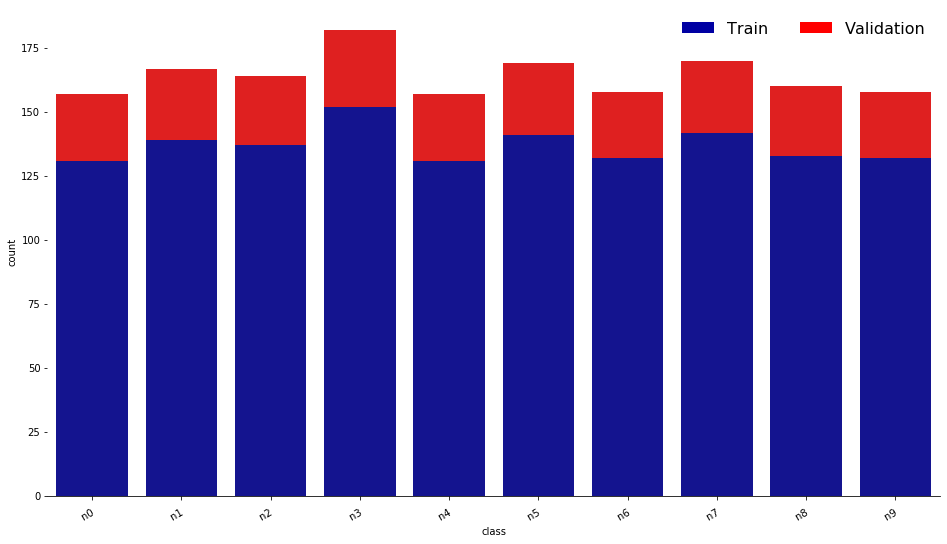

In [5]:
fig = plt.figure(figsize=(16, 9))

sns.barplot(x=labels['Label'], y=labels["Validation Images"]+labels["Train Images"], color = 'red')
bottom_plot = sns.barplot(x=labels['Label'], y=labels["Train Images"],color="#0000A3")

topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')

l = plt.legend([bottombar, topbar], ['Train', 'Validation'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

sns.despine(left=True)
bottom_plot.set_ylabel("count")
bottom_plot.set_xlabel("class")
bottom_plot.set_xticklabels(labels=labels.Label, rotation=30)
plt.show()

In [6]:
labels = labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

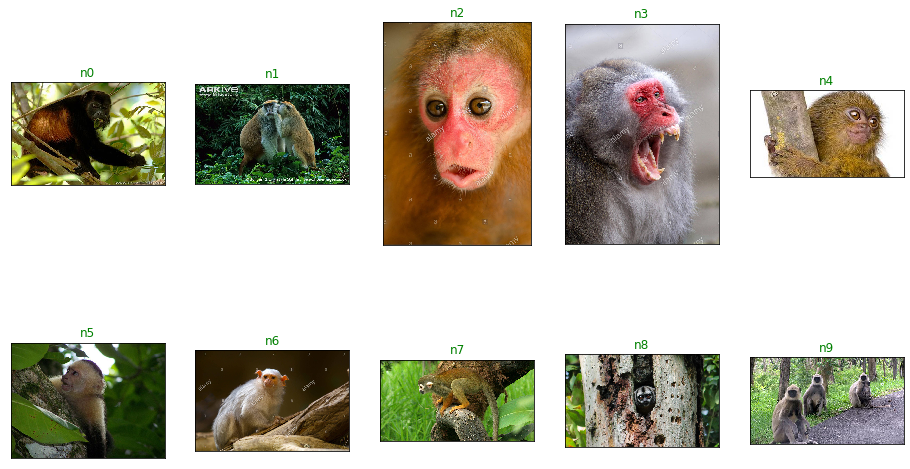

In [7]:
# 各类猴子展示
train_paths = os.listdir(TRAIN_PATH)

fig = plt.figure(figsize=(16, 9))
for i, class_path in enumerate(train_paths):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    monkey_paths = os.listdir(os.path.join(TRAIN_PATH,class_path))
    monkey_path = os.path.join(TRAIN_PATH,class_path,monkey_paths[0])
    image=Image.open(monkey_path)
    ax.imshow(image)
    ax.set_title("{}".format(class_path),color="green")

**加载数据集**

In [8]:
N_CLASSES = 10
MODEL_CHECK_WEIGHT_NAME = 'monkey2.h5'

LR = 1e-3
height=128
width=128
channels=3
seed=1337
batch_size = 64
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20

# 训练集
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAIN_PATH, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

# 验证集
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(VALID_PATH, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

# 测试集
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_PATH, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = len(train_generator)
validation_num = len(validation_generator) 
test_num = len(test_generator)


Found 1048 images belonging to 10 classes.
Found 222 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


**模型**

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(height, width, channels)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

**编译模型**

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
________

In [11]:
checkpoint = ModelCheckpoint(MODEL_CHECK_WEIGHT_NAME, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]#, stopper]

In [12]:
history = model.fit_generator(train_generator, steps_per_epoch= train_num,             # batch_size,
                              epochs=epochs,
                              validation_data=train_generator, validation_steps= validation_num,       # batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
17/17 [==============================] - 34s 2s/step - loss: 2.3297 - acc: 0.1028 - val_loss: 2.2739 - val_acc: 0.1055

Epoch 00001: val_acc improved from -inf to 0.10547, saving model to monkey.h5
Epoch 2/100
17/17 [==============================] - 28s 2s/step - loss: 2.2404 - acc: 0.1628 - val_loss: 2.1160 - val_acc: 0.2773

Epoch 00002: val_acc improved from 0.10547 to 0.27734, saving model to monkey.h5
Epoch 3/100
17/17 [==============================] - 30s 2s/step - loss: 1.9050 - acc: 0.3174 - val_loss: 1.7336 - val_acc: 0.3633

Epoch 00003: val_acc improved from 0.27734 to 0.36328, saving model to monkey.h5
Epoch 4/100
17/17 [==============================] - 28s 2s/step - loss: 1.7999 - acc: 0.3496 - val_loss: 1.6818 - val_acc: 0.3935

Epoch 00004: val_acc improved from 0.36328 to 0.39352, saving model to monkey.h5
Epoch 5/100
17/17 [==============================] - 31s

17/17 [==============================] - 32s 2s/step - loss: 0.5373 - acc: 0.7987 - val_loss: 0.5157 - val_acc: 0.8320

Epoch 00040: val_acc did not improve from 0.84766
Epoch 41/100
17/17 [==============================] - 30s 2s/step - loss: 0.5358 - acc: 0.8023 - val_loss: 0.4668 - val_acc: 0.8438

Epoch 00041: val_acc did not improve from 0.84766
Epoch 42/100
17/17 [==============================] - 30s 2s/step - loss: 0.5357 - acc: 0.8147 - val_loss: 0.5454 - val_acc: 0.7963

Epoch 00042: val_acc did not improve from 0.84766
Epoch 43/100
17/17 [==============================] - 31s 2s/step - loss: 0.4862 - acc: 0.8247 - val_loss: 0.4539 - val_acc: 0.8281

Epoch 00043: val_acc did not improve from 0.84766
Epoch 44/100
17/17 [==============================] - 34s 2s/step - loss: 0.4871 - acc: 0.8327 - val_loss: 0.5037 - val_acc: 0.8008

Epoch 00044: val_acc did not improve from 0.84766
Epoch 45/100
17/17 [==============================] - 30s 2s/step - loss: 0.5449 - acc: 0.8035 - v

17/17 [==============================] - 28s 2s/step - loss: 0.2480 - acc: 0.9068 - val_loss: 0.2847 - val_acc: 0.9062

Epoch 00084: val_acc did not improve from 0.95312
Epoch 85/100
17/17 [==============================] - 30s 2s/step - loss: 0.2423 - acc: 0.9245 - val_loss: 0.1514 - val_acc: 0.9648

Epoch 00085: val_acc improved from 0.95312 to 0.96484, saving model to monkey.h5
Epoch 86/100
17/17 [==============================] - 34s 2s/step - loss: 0.1914 - acc: 0.9336 - val_loss: 0.2507 - val_acc: 0.9023

Epoch 00086: val_acc did not improve from 0.96484
Epoch 87/100
17/17 [==============================] - 33s 2s/step - loss: 0.2958 - acc: 0.8872 - val_loss: 0.2738 - val_acc: 0.9062

Epoch 00087: val_acc did not improve from 0.96484
Epoch 88/100
17/17 [==============================] - 32s 2s/step - loss: 0.2181 - acc: 0.9234 - val_loss: 0.2700 - val_acc: 0.8828

Epoch 00088: val_acc did not improve from 0.96484
Epoch 89/100
17/17 [==============================] - 33s 2s/step -

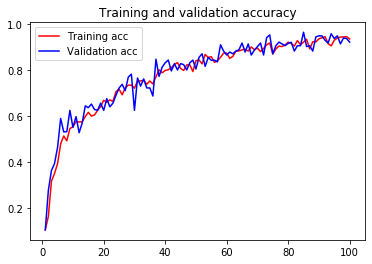

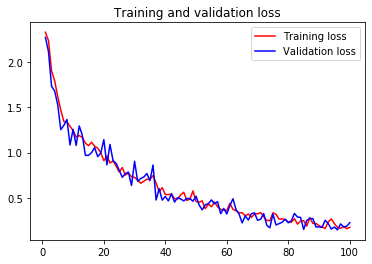

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [14]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

In [15]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [16]:
from keras.models import load_model
model_trained = load_model(MODEL_CHECK_WEIGHT_NAME)

In [17]:
Y_pred = model_trained.predict_generator(test_generator, test_num)
Y_pred_classes = np.argmax(Y_pred, axis = 1)

In [18]:
Y_pred_classes

array([9, 0, 9, 0, 9, 0, 9, 0, 9, 9, 1, 7, 9, 1, 1, 1, 1, 1, 8, 1, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 6, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 7, 4, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 6, 5, 3, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 7, 7, 4, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9, 9, 9, 9, 5, 5, 9], dtype=int64)

In [19]:
len(Y_pred_classes),len(test_generator.classes)

(100, 100)

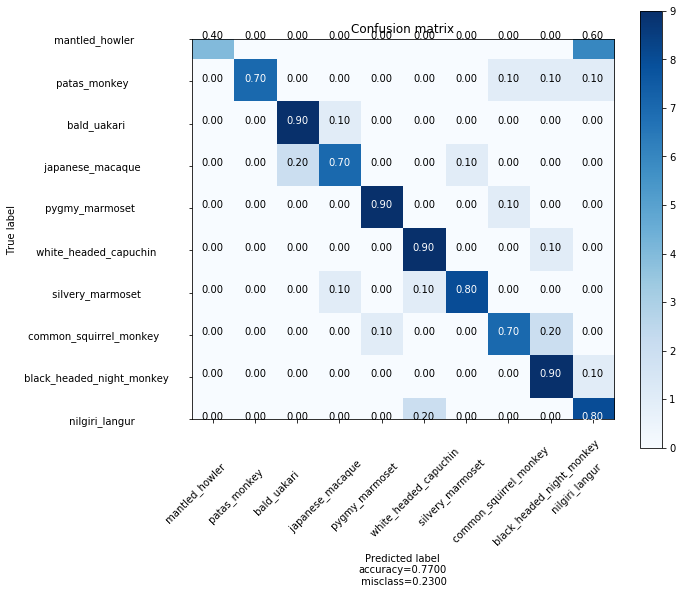

In [20]:
confusion_mtx = confusion_matrix(y_true = test_generator.classes,y_pred = Y_pred_classes)
# 画混淆曲线
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

In [21]:
print(metrics.classification_report(test_generator.classes, Y_pred_classes,target_names=labels))

                                 precision    recall  f1-score   support

 mantled_howler                       1.00      0.40      0.57        10
 patas_monkey                         1.00      0.70      0.82        10
 bald_uakari                          0.82      0.90      0.86        10
 japanese_macaque                     0.78      0.70      0.74        10
 pygmy_marmoset                       0.90      0.90      0.90        10
 white_headed_capuchin                0.75      0.90      0.82        10
 silvery_marmoset                     0.89      0.80      0.84        10
 common_squirrel_monkey               0.78      0.70      0.74        10
 black_headed_night_monkey            0.69      0.90      0.78        10
 nilgiri_langur                       0.50      0.80      0.62        10

                       accuracy                           0.77       100
                      macro avg       0.81      0.77      0.77       100
                   weighted avg       0.81      0